In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


In [2]:
import pandas as pd

In [3]:
import random
import glob # borrar ficheros con patrones
import shutil #copiar ficheros

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit #para realizar el muestre

In [5]:
!wget --no-check-certificate \
    https://www.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip \
    -O /tmp/covid19.zip

--2021-08-08 00:37:53--  https://www.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip
Resolving www.recod.ic.unicamp.br (www.recod.ic.unicamp.br)... 143.106.7.142
Connecting to www.recod.ic.unicamp.br (www.recod.ic.unicamp.br)|143.106.7.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://intranet.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip [following]
--2021-08-08 00:37:54--  http://intranet.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip
Resolving intranet.recod.ic.unicamp.br (intranet.recod.ic.unicamp.br)... 143.106.7.151
Connecting to intranet.recod.ic.unicamp.br (intranet.recod.ic.unicamp.br)|143.106.7.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780769059 (745M) [application/zip]
Saving to: ‘/tmp/covid19.zip’

/tmp/covid19.zip    100%[===================>] 744.60M  8.66MB/s    in 3m 35s  

2021-08-08 00:41:30 (3.46 MB/s) - ‘/tmp/covid19.zip’ saved [780769059/780769059]



In [6]:
import zipfile

local_zip = '/tmp/covid19.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
#ruta donde se descomprimen los fichereros del dataset
os.listdir("/tmp/COVID-19_Radiography_Dataset")

['Viral Pneumonia.metadata.xlsx',
 'Normal.metadata.xlsx',
 'README.md.txt',
 'Normal',
 'COVID.metadata.xlsx',
 'Lung_Opacity',
 'Lung_Opacity.metadata.xlsx',
 'Viral Pneumonia',
 'COVID']

In [8]:
#removemos los ficheros que no usaremos 
py_files = glob.glob('/tmp/COVID-19_Radiography_Dataset/*.*')
for py_file in py_files:
    try:
        os.remove(py_file)
    except OSError as e:
        print(f"Error:{ e.strerror}")

In [9]:
root_dir    = '/tmp/COVID-19_Radiography_Dataset' #directorio origen

os.listdir(root_dir)

['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

In [10]:
class_names = ['normal','opacity', 'viral', 'covid']
source_dirs = ['Normal','Lung_Opacity','Viral Pneumonia', 'COVID']

In [11]:
#se cambia el nombre de las carpetas
for i, d in enumerate(source_dirs):
    os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

In [12]:
os.listdir(root_dir)

['normal', 'opacity', 'covid', 'viral']

In [13]:
#dataframe de las imagenes y clases
list_files=[]
for dir in os.listdir(root_dir):
  directory = os.path.join(root_dir,dir) # directorios de las clases
  if os.path.isdir(directory):
    for img in os.listdir(directory):
      list_files.append([os.path.join(dir,img),dir]) #lista de todos los ficheros de cada directorio
df = pd.DataFrame(list_files, columns=['id','clase'])

In [ ]:
df

,id,clase
0,opacity/Lung_Opacity-4965.png,opacity
1,opacity/Lung_Opacity-166.png,opacity
2,opacity/Lung_Opacity-3229.png,opacity
3,opacity/Lung_Opacity-1.png,opacity
4,opacity/Lung_Opacity-1440.png,opacity
...,...,...
21160,viral/Viral Pneumonia-643.png,viral
21161,viral/Viral Pneumonia-212.png,viral
21162,viral/Viral Pneumonia-953.png,viral
21163,viral/Viral Pneumonia-151.png,viral


In [14]:
df.groupby("clase").agg(frequency=("clase", "count"))

,frequency
clase,
covid,3616
normal,10192
opacity,6012
viral,1345


In [ ]:
df["clase"].unique()

array(['normal', 'opacity', 'covid', 'viral'], dtype=object)

In [15]:
#Haremos un submuestreo a las clases con mas ejemplos que la clase COVID
def balance_dataset(focus_class, df):
  classes = df["clase"].unique()
  classes_df_list = []
  focus_class_df = df[df["clase"] == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  ##Dividimos por clases
  for classe in classes:
    class_df = df[df["clase"] == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class+1000:
      class_df = class_df.sample(count_focus_class+1000)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('covid',df)

In [16]:
df.groupby("clase").agg(frequency=("clase", "count"))

,frequency
clase,
covid,3616
normal,4616
opacity,4616
viral,1345


In [17]:
root_dir

'/tmp/COVID-19_Radiography_Dataset'

In [18]:
os.mkdir(root_dir+"/train")
os.mkdir(root_dir+"/test")


os.mkdir(root_dir+"/train/covid")
os.mkdir(root_dir+"/test/covid")

os.mkdir(root_dir+"/train/viral")
os.mkdir(root_dir+"/test/viral")

os.mkdir(root_dir+"/train/normal")
os.mkdir(root_dir+"/test/normal")

os.mkdir(root_dir+"/train/opacity")
os.mkdir(root_dir+"/test/opacity")


In [19]:
#creamos la función que hará el split de nuestros conjuntos
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)#se divide de forma stratificada
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['clase']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['clase'][train_index], df['clase'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

In [20]:
traindf,testdf = split_dataset(df,test_size = 0.10)

In [21]:
print(traindf['clase'].value_counts())

normal     4154
opacity    4154
covid      3254
viral      1211
Name: clase, dtype: int64


In [22]:
print(testdf['clase'].value_counts())


opacity    462
normal     462
covid      362
viral      134
Name: clase, dtype: int64


In [23]:
#visualizamos que todos nuestros conjuntos tienen imagenes diferentes entre ellos 
repetidos=pd.merge(traindf,testdf,how='left',on=['id'])
print(repetidos['clase_y'].unique())


[nan]


In [24]:
for i in traindf.index:
  shutil.copy(root_dir+"/"+traindf['id'][i],  root_dir+"/train/"+traindf['clase'][i])

In [25]:
for i in testdf.index:
  shutil.copy(root_dir+"/"+testdf['id'][i],  root_dir+"/test/"+testdf['clase'][i])

In [26]:
#conteo de ficheros en la clase train
tmp=0
print("Cantidad de datos en Train")
for i in traindf["clase"].unique():
  train=len(os.listdir("/tmp/COVID-19_Radiography_Dataset/train/"+i))
  print(i,str(train))
  tmp=tmp+train
print("Ficheros en Train: "+str(tmp))

Cantidad de datos en Train
normal 4154
covid 3254
opacity 4154
viral 1211
Ficheros en Train: 12773


In [27]:
#conteo de ficheros en la clase test
tmp=0
print("Cantidad de ficheros en Test")
for i in testdf["clase"].unique():
  test=len(os.listdir("/tmp/COVID-19_Radiography_Dataset/test/"+i))
  print(i,str(test))
  tmp=tmp+test
print("ficheros en Test "+str(tmp))

Cantidad de ficheros en Test
viral 134
opacity 462
normal 462
covid 362
ficheros en Test 1420


# Creating Custom Dataset

In [28]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #Verificar se o aquivo realmente é imagem 'png'
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid','opacity']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [29]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),#se transforma el tamano de las imagenes de entrada a 224×224
    torchvision.transforms.RandomHorizontalFlip(),#de forma aleatoria se inviert de forma horizontal
    torchvision.transforms.ToTensor(),#Se convierte a tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])#Media y varianza de imagenet
])

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                     std = [0.229, 0.224, 0.225])
])

In [30]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare Loader

In [31]:
train_dirs = {
    'normal': '/tmp/COVID-19_Radiography_Dataset/train/normal',
    'viral': '/tmp/COVID-19_Radiography_Dataset/train/viral',
    'covid': '/tmp/COVID-19_Radiography_Dataset/train/covid',
    'opacity': '/tmp/COVID-19_Radiography_Dataset/train/opacity'
}

In [32]:
test_dirs = {
    'normal': '/tmp/COVID-19_Radiography_Dataset/test/normal',
    'viral': '/tmp/COVID-19_Radiography_Dataset/test/viral',
    'covid': '/tmp/COVID-19_Radiography_Dataset/test/covid',
    'opacity': '/tmp/COVID-19_Radiography_Dataset/test/opacity'
}

In [33]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 4154 normal examples
Found 1211 viral examples
Found 3254 covid examples
Found 4154 opacity examples


In [34]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 462 normal examples
Found 134 viral examples
Found 362 covid examples
Found 462 opacity examples


In [35]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = 6, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = 6, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2129
Number of test batches 237


In [36]:
class_names = ['normal','viral','covid','opacity']

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

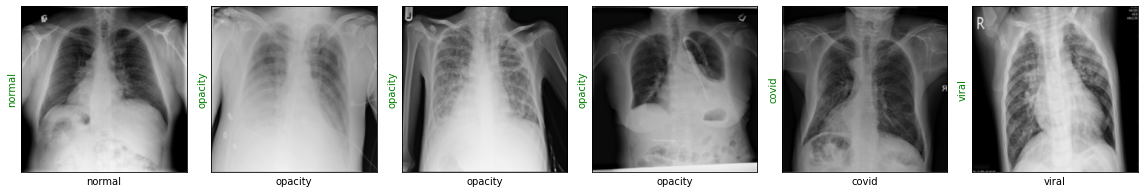

In [37]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

# Creating the Model

In [40]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print('Dispositivo disponible:', device)

Dispositivo disponible: cuda


In [41]:
gnet = torchvision.models.googlenet(pretrained=True)

print(gnet)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth



GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, trac

In [42]:
gnet.fc = torch.nn.Linear(in_features = 1024, out_features = 4)
gnet = gnet.to(device)
loss_fngnet     = torch.nn.CrossEntropyLoss()
optimizer_gnet   = torch.optim.Adam(gnet.parameters(), lr = 3e-5)

In [43]:
def show_predsgnet():
    gnet.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs  = gnet(images)
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


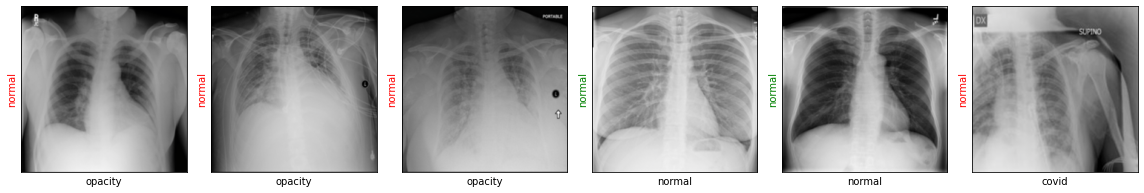

In [44]:
show_predsgnet()

In [45]:
train_losses, test_losses = [], []
def train2(epochs):
    print('Starting training..')
    
    rs = '------------------------------------------------------------------'
    print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
    print(rs)
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        gnet.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            images = images.to(device)
            labels = labels.to(device)
            optimizer_gnet.zero_grad()
            outputs = gnet(images)
            loss = loss_fngnet(outputs, labels)
            loss.backward()
            optimizer_gnet.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                gnet.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = gnet(images)
                    loss = loss_fngnet(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    
                    accuracy += torch.sum(preds == labels.data)

                val_loss /= (val_step + 1)
                train_loss /= (train_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                
                train_losses.append(train_loss)
                test_losses.append(val_loss)

                #show_predsgnet()

                gnet.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [46]:
%%time

train2(epochs=3)

Starting training..
Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
Starting epoch 1/3
Evaluating at step 0
Validation Loss: 1.4093, Accuracy: 0.2697
Evaluating at step 20
Validation Loss: 1.3319, Accuracy: 0.3049
Evaluating at step 40
Validation Loss: 1.2078, Accuracy: 0.5000
Evaluating at step 60
Validation Loss: 1.0473, Accuracy: 0.6725
Evaluating at step 80
Validation Loss: 0.9303, Accuracy: 0.7092
Evaluating at step 100
Validation Loss: 0.8718, Accuracy: 0.7289
Evaluating at step 120
Validation Loss: 0.8264, Accuracy: 0.7331
Evaluating at step 140
Validation Loss: 0.7718, Accuracy: 0.7408
Evaluating at step 160
Validation Loss: 0.7515, Accuracy: 0.7310
Evaluating at step 180
Validation Loss: 0.7183, Accuracy: 0.7542
Evaluating at step 200
Validation Loss: 0.6819, Accuracy: 0.7577
Evaluating at step 220
Validation Loss: 0.6872, Accuracy: 0.7620
Evaluating at step 240
Validation Loss: 0.6221, Accuracy: 0

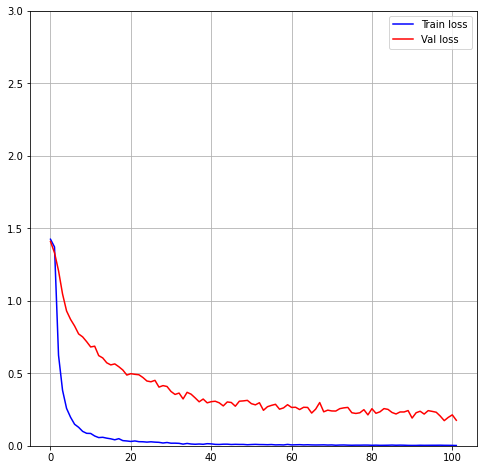

In [47]:
fig1, axs = plt.subplots(figsize=(8,8))

axs.plot(train_losses, 'b-', label='Train loss')
axs.plot(test_losses, 'r-', label='Val loss')


axs.set_ylim([0, 3])

plt.grid()
plt.legend()
plt.show()

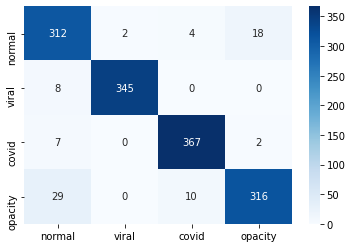

In [48]:
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long)
lbllist=torch.zeros(0,dtype=torch.long)

gnet.eval()
for val_step, (images, labels) in enumerate(dl_test):
  images = images.to(device)
  labels = labels.to(device)
  outputs = gnet(images)

  _, preds = torch.max(outputs, 1)
  
  # Append batch prediction results
  predlist=torch.cat([predlist,preds.view(-1).cpu()])
  lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
#print(conf_mat)
import seaborn as sns
import pandas as pd
df_cm = pd.DataFrame(conf_mat, index = class_names,
                  columns = class_names)
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt=".0f")

In [ ]:
torch.save(gnet.state_dict(), '/tmp/COVID-19_Radiography_Dataset/my_gnet.pth')

In [ ]:
#Cargamos el modelo guardado
modelgnet_ = torchvision.models.googlenet(pretrained=True)
modelgnet_.fc = torch.nn.Linear(in_features = 1024, out_features = 4)
modelgnet_.load_state_dict(torch.load('/tmp/COVID-19_Radiography_Dataset/my_gnet.pth'))

<All keys matched successfully>

In [ ]:
import torchvision.transforms as T
def transformar_imagen(name):
  '''
  Pre procesamiento de la imagen
  '''
  image = Image.open(name).convert('RGB')

  
  transf = T.Compose([T.Resize(size = (224, 224)),
                      #T.CenterCrop(224),
                      T.ToTensor(), # entre 0 y 1
                      T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]) # medias y desviacion estandar (Welford's method)
  #image = Image.open(name)
  # Tamaño (3,224,224) => (1, 3, 224, 224)
  return transf(image).unsqueeze(0) # tensor singleton

In [ ]:
def prediccion2(network, name):
  '''
  Predicción con grado de confidencia
  '''
  tensor = transformar_imagen(name)
  network.eval()
  output = network(tensor)
  #output = F.softmax(pred, dim=-1)
  _, pred = torch.max(output,1)
  #index = str(val.item())
  show_images(tensor, pred, pred)
  return pred
  

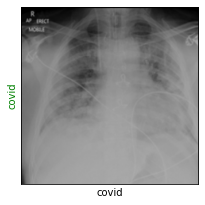

In [ ]:
pred_gnet = prediccion2(modelgnet_, '/tmp/COVID-19_Radiography_Dataset/test/covid/COVID-1032.png')

In [ ]:
print(pred_gnet)               

tensor([2])
